In [1]:
import jax.numpy as jnp
from jax import grad, jit
import jax
from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from deap import base, creator, tools, algorithms
import random
import scipy.io
import dipy as dp
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import time
import numpy as np
import sys
from matplotlib.animation import FuncAnimation

In [2]:
a = np.array([[[1,2,3]]])
jnp.asarray(a, dtype = 'int16')

Array([[[1, 2, 3]]], dtype=int16)

In [4]:
def load_nearfield_jax(file_name, grid_id ='E', x_id = 'x', y_id = 'y'):
    """Imports the electric field data from a .mat file. 
    input:
        filename: (str) name of the .mat file to import
    output:
        E_grid: (n x m x 3 jnp-array) 3d electric field grid to be processed as a jax numpy array"""
    
    # Open the .mat file using h5py
    f = h5py.File(file_name, 'r')
    E_grid= np.array(f[grid_id])
    E_grid = E_grid['real'] + 1j*E_grid['imag']

    x = f[x_id]
    y = f[y_id]
    
    # Swap E_grid axes from (3 x n x m) to (n x m x 3)
    E_grid = np.swapaxes(E_grid, 0, 2)
    E_grid = np.swapaxes(E_grid, 0, 1)
    
    # Convert to JAX arrays
    E_grid = jnp.array(E_grid)

    return dp.Nearfield(E_grid, jnp.array(x), jnp.array(y))

In [5]:
def calculate_far_field_efficiency(positions, wavelength, gain):
    # Convert positions to JAX array for compatibility with the simulation
    positions_np = jnp.array(positions).reshape(-1, 3)
    scatterers = [dp.ScatteringPoint(pos) for pos in positions]
    sim.scatterers = scatterers
    ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
    efficiency = sim.get_efficiency_by_theta(wavelength, gain=gain)
    return jnp.array(efficiency[-1]) if efficiency is not None else 0.0

@jit
def constraint_penalty(positions):
    positions = positions.reshape(-1, 3)
    dists = jnp.sqrt(jnp.sum((positions[:, None, :] - positions[None, :, :]) ** 2, axis=-1))
    min_distance = 0.12e-6  # Minimum allowed distance
    violations = jnp.minimum(dists - min_distance, 0.0)  # Negative if violation
    penalty = jnp.sum(jnp.abs(violations))
    return penalty * 1e6  # Large penalty for violations

def combined_objective_function(positions, wavelength, gain):
    efficiency = calculate_far_field_efficiency(positions, wavelength, gain)
    penalty = constraint_penalty(positions)
    return -efficiency + penalty

# Compute gradients using JAX
grad_combined_objective_function = jit(grad(combined_objective_function))

# Parameters for the simulation
wavelength = .673e-6  # frequency of light baseline: 1/.6454
n = 1.4  # index of refraction baseline: 1.4

# Hexagonal Grid Structure
n_rows = 20  # number of rows in the grid baseline: 12
n_cols = 20  # number of columns in the grid baseline: 12
spacing = .33e-6  # spacing between dipoles baseline: .33
align = jnp.array([1*spacing/2, 0, 0])
scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)

# Global simulation object
sim = dp.DipoleSimulation(background_index=1.4)

# Create and add the nearfield
nearfield_default = dp.load_nearfield('matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
sim.add_nearfield(nearfield_default, "control_nearfield")

#add the initial positions of scatterers into the nearfield
sim.add_scatterers([dp.ScatteringPoint(pos) for pos in scattering_centers])

# Wrapper functions to convert between JAX and NumPy
def numpy_combined_objective_function(positions, wavelength, gain):
    return float(combined_objective_function(positions, wavelength, gain))

def numpy_grad_combined_objective_function(positions, wavelength, gain):
    return np.array(grad_combined_objective_function(positions, wavelength, gain))

# Optimize
gain = 1
result = minimize(
    fun=numpy_combined_objective_function, 
    x0=scattering_centers.flatten(), 
    args=(wavelength, gain), 
    method='L-BFGS-B',
    jac=numpy_grad_combined_objective_function
)

optimal_positions = result.x.reshape(-1, 3)
print("Optimal Positions:\n", optimal_positions)

# Plot the optimized far field
scatterers = [dp.ScatteringPoint(pos) for pos in optimal_positions]
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
print(optimized_ff)
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="optimized_farfield.png")

float64


/Users/jeddybennett/Desktop/color-center/src/dipy/dipy/farfield.py:81: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sampled_intensities = sampled_intensities.at[i].set(jnp.asarray(intensity_grid, dtype = 'float64').at[nearest_y, nearest_x])


TypeError: Value '_IndexUpdateRef(Array([[ 0.29362923,  0.27907205,  0.2645149 , ..., -0.2659243 ,
        -0.28054848, -0.29517266],
       [ 0.27132052,  0.25305104,  0.23849387, ..., -0.24357744,
        -0.25820163, -0.2728258 ],
       [ 0.24901181,  0.23074234,  0.21247286, ..., -0.22123058,
        -0.23585476, -0.25047895],
       ...,
       [ 0.1580643 ,  0.14046283,  0.12286136, ..., -0.12358303,
        -0.14123422, -0.15888542],
       [ 0.18152902,  0.16392754,  0.14632607, ..., -0.1470576 ,
        -0.1647088 , -0.18236   ],
       [ 0.20499371,  0.18739223,  0.16979076, ..., -0.17053218,
        -0.18818337, -0.20583457]], dtype=float32), (Array(0, dtype=int32), Array(0, dtype=int32)))' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

Gen 0: Min 15.899999999999999, Max 15.899999999999999, Avg 15.900000000000004, Std 5.329070518200751e-15
Gen 1: Min 15.899999999999999, Max 15.899999999999999, Avg 15.900000000000004, Std 5.329070518200751e-15
Gen 2: Min 15.899999999999999, Max 15.899999999999999, Avg 15.900000000000004, Std 5.329070518200751e-15
Gen 3: Min 15.899999999999999, Max 15.899999999999999, Avg 15.900000000000004, Std 5.329070518200751e-15
Gen 4: Min 15.899999999999999, Max 15.899999999999999, Avg 15.900000000000004, Std 5.329070518200751e-15
Optimal Positions:
 [[-0.02354585  0.17422019  0.29976601]
 [ 0.85945441  0.03000214  0.29106971]
 [-0.02016782  0.85953561  0.18398082]
 [ 0.32387266  0.93949183  0.4389283 ]
 [ 0.08135767  0.30371137  0.22013199]
 [ 0.41262338  0.70873532  0.07474139]
 [ 0.60997428  0.92123194  0.59103113]
 [ 0.25019366  0.15800279  0.13288916]
 [ 0.54125385  0.70139145  0.40258537]
 [-0.06066517  0.19208777  0.67594385]
 [ 0.26763103  0.46570012  0.3927876 ]
 [ 0.4251248   0.2099078  

[[3.89132838e-02 1.18703239e-01 1.21991627e-02 ... 6.47330856e-03
  1.04632255e-02 1.46337124e-02]
 [3.89132838e-02 1.17662047e-01 3.10162041e-02 ... 6.49585889e-03
  5.97966867e-03 8.63983212e-03]
 [3.89132838e-02 6.03753578e-02 3.05300545e-02 ... 3.30253803e-03
  4.10335248e-03 1.65446061e-02]
 ...
 [3.89132838e-02 1.41730619e-02 3.04113456e-02 ... 1.04515933e-02
  5.34372295e-05 2.76371603e-02]
 [3.89132838e-02 6.55854515e-03 2.42283263e-02 ... 1.34056722e-02
  1.52536595e-02 1.40895085e-02]
 [3.89132838e-02 1.18703239e-01 1.21991627e-02 ... 6.47330835e-03
  1.04632258e-02 1.46337125e-02]]


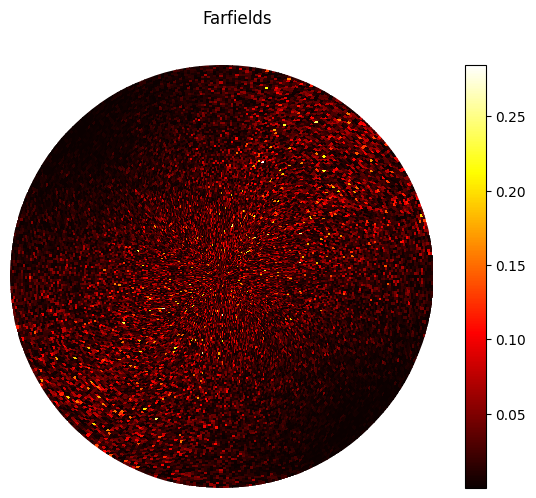

In [5]:
scatterers = [dp.ScatteringPoint(pos) for pos in optimal_positions]
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
print(optimized_ff)
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="optimized_farfield.png")

[[0.00951988 0.13188127 0.51639595 ... 0.05965054 0.05901508 0.05880132]
 [0.00951988 0.13055882 0.51400518 ... 0.00096262 0.00066347 0.0005637 ]
 [0.00951988 0.12942893 0.51232746 ... 0.05721732 0.0582394  0.05858367]
 ...
 [0.00951988 0.1351026  0.52331443 ... 0.4762578  0.47803409 0.47862655]
 [0.00951988 0.13339596 0.51949901 ... 0.22916873 0.22927399 0.22930745]
 [0.00951988 0.13188127 0.51639595 ... 0.05965054 0.05901508 0.05880132]]


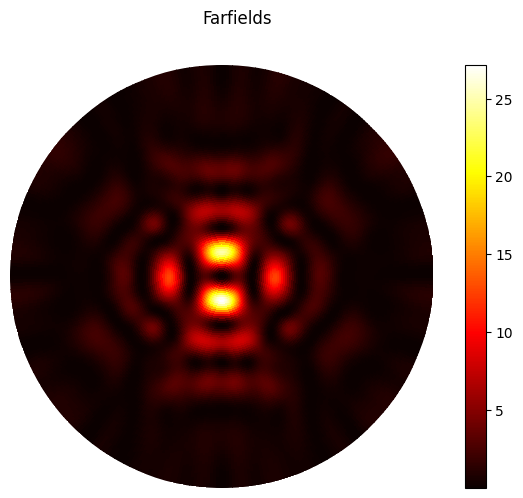

In [6]:
scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
print(optimized_ff)
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="normal_farfield.png")

In [13]:
# Define the Gaussian beam function in spherical coordinates
def gaussian_beam(theta, phi, I0):
    return (I0)**2 * np.exp(-2*(np.tan(theta)**2 / 0.4**2))

# Parameters for the Gaussian beam
I0 = 2.10

# Generate the target Gaussian far field
theta_lim = np.pi
theta_res = 100
#phi_res = int(2 * np.pi * theta_res / theta_lim)
theta = np.linspace(0, 2*theta_lim, theta_res)
phi = np.linspace(0, 2 * np.pi, 400)
Theta, Phi = np.meshgrid(theta, phi)
target_far_field = gaussian_beam(Theta, Phi, I0)

print(target_far_field.shape)

(400, 100)


In [ ]:
# Initialize the DipoleSimulation and load the nearfield
sim = dp.DipoleSimulation(background_index=1.4)
nearfield_default = dp.load_nearfield('matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
sim.add_nearfield(nearfield_default, "control_nearfield")

# Hexagonal Grid Structure
n_rows = 20
n_cols = 20
spacing = 0.33e-6
align = np.array([1 * spacing / 2, 0, 0])
scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)
sim.add_scatterers([dp.ScatteringPoint(pos) for pos in scattering_centers])

scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
print(optimized_ff)
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="normal_farfield.png")


In [14]:
# Define the function to calculate the far field
def calculate_far_field(positions, wavelength, gain):
    positions_np = np.array(positions).reshape(-1, 3)
    scatterers = [dp.ScatteringPoint(pos) for pos in positions_np]
    sim.scatterers = scatterers
    far_field = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
    return far_field

# Define the error function
def calculate_error(far_field, target_far_field):
    return np.mean((far_field - target_far_field) ** 2)

# Define the penalty function for constraints
def constraint_penalty(positions):
    positions = positions.reshape(-1, 3)
    dists = np.sqrt(np.sum((positions[:, None, :] - positions[None, :, :]) ** 2, axis=-1))
    min_distance = 0.12e-6  # Minimum allowed distance
    violations = np.minimum(dists - min_distance, 0.0)  # Negative if violation
    penalty = np.sum(np.abs(violations))
    return penalty * 1e6  # Large penalty for violations

# Combined objective function
def combined_objective_function(positions, wavelength, gain):
    far_field = calculate_far_field(positions, wavelength, gain)
    error = calculate_error(far_field, target_far_field)
    penalty = constraint_penalty(positions)
    return error + penalty


In [ ]:
# include a free parameter to control the numerical aperture
# once we optimize, we can pick different numerical apertures

In [15]:
# Parameters for the simulation
wavelength = .673e-6
n = 1.4  # index of refraction baseline: 1.4

# Hexagonal Grid Structure
n_rows = 12  # number of rows in the grid baseline: 12
n_cols = 12  # number of columns in the grid baseline: 12
spacing = .33e-6  # spacing between dipoles baseline: .33
align = np.array([1*spacing/2, 0, 0])

# Global simulation object
sim = dp.DipoleSimulation(background_index=1.4)

# Create and add the nearfield
nearfield_default = dp.load_nearfield(file_name='matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
sim.add_nearfield(nearfield_default, "control_nearfield")

scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)
scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]

# Create and add the dipole grid
sim.add_scatterers(scatterers)

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(scattering_centers.flatten()))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    gain = 1
    positions = np.array(individual).reshape(-1, 3)  # Ensure positions are properly shaped
    return combined_objective_function(positions, wavelength, gain),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=20)
toolbox.register("evaluate", evaluate)

population = toolbox.population(n=1000)

# Genetic Algorithm process
NGEN = 5
CXPB, MUTPB = 0.8, 0.8

for gen in range(NGEN):
    # Select and clone the offspring
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    length = len(population)
    mean = np.mean(fits)
    std = np.std(fits)
    min_fit = np.min(fits)
    max_fit = np.max(fits)

    print(f"Gen {gen}: Min {min_fit}, Max {max_fit}, Avg {mean}, Std {std}")

best_ind = tools.selBest(population, 1)[0]
optimal_positions = np.array(best_ind).reshape(-1, 3)
print("Optimal Positions:\n", optimal_positions)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Gen 0: Min 22.5540826559262, Max 22.57436093339761, Avg 22.57085608348094, Std 0.002701050502858608
Gen 1: Min 22.54727076972351, Max 22.574159151176612, Avg 22.56830719083263, Std 0.0043400149083205695
Gen 2: Min 22.53961319681124, Max 22.574101475584925, Avg 22.56601317003309, Std 0.005663318894852704
Gen 3: Min 22.531175691378362, Max 22.573993759694652, Avg 22.563729038251164, Std 0.006858752165903092
Gen 4: Min 22.52913876972579, Max 22.574000871585692, Avg 22.561695601041784, Std 0.008003268843992193
Optimal Positions:
 [[ 7.76352983e-01  5.13725977e-01  4.71450246e-01]
 [ 4.64465770e-01  9.25899962e-01  3.31891369e-01]
 [ 7.62395305e-01  4.04019999e-01  5.10354371e-01]
 [ 5.29772083e-01  4.86690054e-01  6.81683572e-01]
 [ 4.96941946e-01  1.83975395e-01  3.34177946e-01]
 [ 5.81380844e-01  1.07298170e+00  7.44702474e-01]
 [ 5.04255791e-01  2.37178374e-01  7.82359020e-01]
 [ 4.21981575e-01  2.00425395e-01  9.32906225e-01]
 [ 9.67938291e-01  1.54779818e-01  6.69945217e-01]
 [ 7.4683

(169, 3)


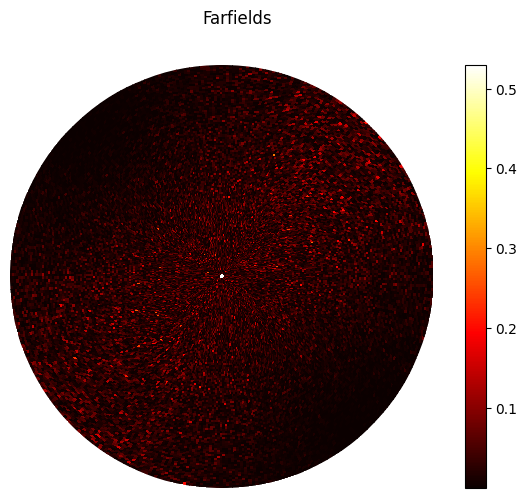

In [20]:
worst_ind = tools.selWorst(population, 1)[0]
experimental_positions = np.array(best_ind).reshape(-1, 3)
scatterers = [dp.ScatteringPoint(pos) for pos in experimental_positions]
print(optimal_positions.shape)
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="optimized_farfield.png")

(169, 3)


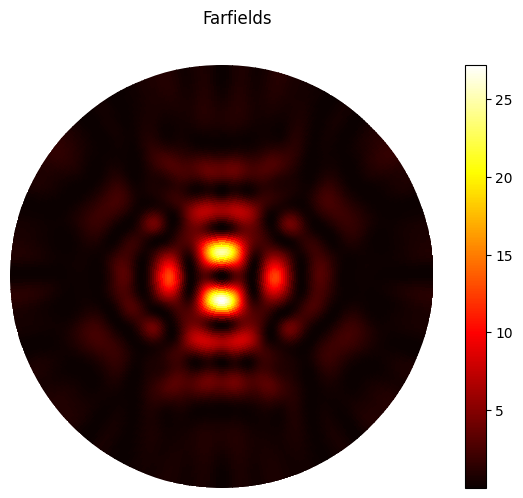

In [19]:
scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]
print(scattering_centers.shape)
sim.scatterers = scatterers
optimized_ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
dp.plotfarfield_2D(optimized_ff, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="normal_farfield.png")

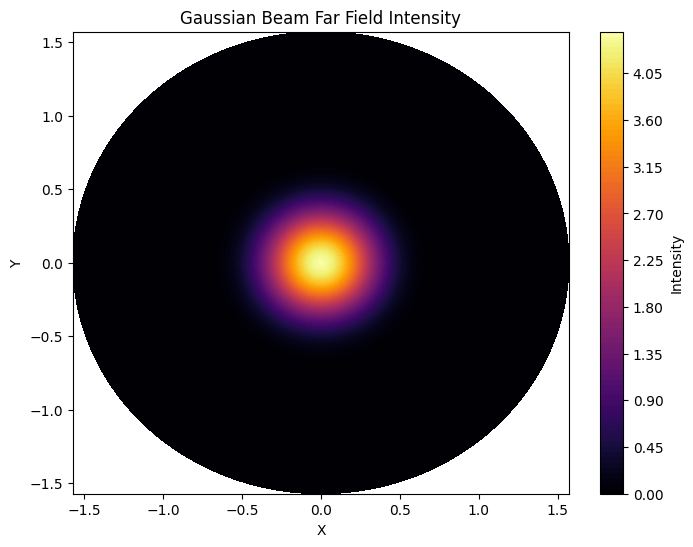

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian beam function in spherical coordinates
def gaussian_beam(theta, phi, I0):
    return (I0)**2 * np.exp(-2*(np.tan(theta)**2 / .5**2))

# Parameters for the Gaussian beam
I0 = 2.10
theta_lim = np.pi/2
theta_res = 100
phi_res = int(2*np.pi * theta_res / theta_lim)
theta = np.linspace(0, theta_lim, theta_res)
phi = np.linspace(0, 2 * np.pi, phi_res)
Theta, Phi = np.meshgrid(theta, phi)
target_far_field = gaussian_beam(Theta, Phi, I0)

# Convert spherical coordinates to Cartesian coordinates for plotting
X = Theta * np.cos(Phi)
Y = Theta * np.sin(Phi)

# Plot the intensity as a heat map
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, target_far_field, 100, cmap='inferno')
plt.colorbar(label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Beam Far Field Intensity')
plt.show()


In [4]:
# Define the function to calculate the far field
def calculate_far_field(positions, wavelength, gain):
    positions_np = np.array(positions).reshape(-1, 3)
    scatterers = [dp.ScatteringPoint(pos) for pos in positions_np]
    sim.scatterers = scatterers
    far_field = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
    return far_field

In [5]:
def constraint_penalty(positions):
    positions = positions.reshape(-1, 3)
    dists = np.sqrt(np.sum((positions[:, None, :] - positions[None, :, :]) ** 2, axis=-1))
    min_distance = 0.4e-6  # Minimum allowed distance
    violations = np.minimum(dists - min_distance, 0.0)  # Negative if violation
    penalty = np.sum(jnp.abs(violations))
    return penalty * 1e6  # Large penalty for violations

In [3]:
# Define the Gaussian beam function in spherical coordinates
def gaussian_beam(theta, phi, I0):
    return (I0)**2 * np.exp(-2*(np.tan(theta)**2 / .5**2))

# Parameters for the Gaussian beam
I0 = 2.10
theta_lim = np.pi/2
theta_res = 100
phi_res = int(2*np.pi * theta_res / theta_lim)
theta = np.linspace(0, theta_lim, theta_res)
phi = np.linspace(0, 2 * np.pi, phi_res)
Theta, Phi = np.meshgrid(theta, phi)
target_far_field = gaussian_beam(Theta, Phi, I0)

# Flatten the target far field for easier comparison
target_far_field_flat = target_far_field.flatten()

In [7]:
# Hexagonal Grid Structure
n_rows = 10
n_cols = 10
spacing = 0.33e-6
align = np.array([1 * spacing / 2, 0, 0])
scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)
sim.add_scatterers([dp.ScatteringPoint(pos) for pos in scattering_centers])
positions = scattering_centers.flatten()
wavelength = .673e-6
gain = 1

print(np.sum((calculate_far_field(positions, wavelength, gain).flatten() - target_far_field_flat.flatten())**2))
      

NameError: name 'sim' is not defined

In [9]:
# Define the Gaussian beam function in spherical coordinates
def gaussian_beam(theta, phi, I0):
    return (I0)**2 * theta * np.exp(-2*(np.tan(theta)**2 / .5**2))

# Parameters for the Gaussian beam
I0 = 2.10
theta_lim = np.pi/2
theta_res = 100
phi_res = int(2*np.pi * theta_res / theta_lim)
theta = np.linspace(0, theta_lim, theta_res)
phi = np.linspace(0, 2 * np.pi, phi_res)
Theta, Phi = np.meshgrid(theta, phi)
target_far_field = gaussian_beam(Theta, Phi, I0)

# Flatten the target far field for easier comparison
target_far_field_flat = target_far_field.flatten()
wavelength = .673e-6
gain = 1
# Define the error function
def error_function(positions, target_far_field, penalty_weight=1e6, min_distance=0.15e-6):
    
    #calculate the updated far field
    simulated_far_field = calculate_far_field(positions, wavelength, gain).flatten()
    
    #calculate error
    error = np.sum((simulated_far_field - target_far_field)**2)

    #penalty for overlapping holes
    positions = positions.reshape(-1,3)
    dists = np.sqrt(np.sum((positions[:, None, :] - positions[None, :, :]) ** 2, axis=-1))
    violations = np.minimum(dists - min_distance, 0.0)  # Negative if violation
    penalty = np.sum(np.abs(violations))
    return error + (penalty * 1e15)

# Define a function to compute the gradient (this is an approximation using finite differences)
def compute_gradient(positions, wavelength, target_far_field_flat, epsilon=1e-5):
    original_far_field = calculate_far_field(positions, wavelength, gain=1)
    original_error = error_function(positions, target_far_field_flat)
    
    gradients = np.zeros_like(positions)
    positions = np.array(positions).reshape(-1, 3)
    for i in range(len(positions)):
        for j in range(3):
            
            # Perturb the dipole position
            positions[i, j] += epsilon
            perturbed_far_field = calculate_far_field(positions.flatten(), wavelength, gain=1)
            perturbed_error = error_function(positions, target_far_field_flat)
            
            # Compute the gradient
            gradients = gradients.reshape(-1, 3)
            gradients[i, j] = (perturbed_error - original_error) / epsilon
            
            # Reset the dipole position
            positions[i, j] -= epsilon
    
    return gradients.flatten()

# Gradient descent parameters
initial_learning_rate = 1e-10
learning_rate = initial_learning_rate
num_iterations = 20
momentum_factor = 0.9
velocity = 0

# Initialize the DipoleSimulation and load the nearfield
sim = dp.DipoleSimulation(background_index=1.4)
nearfield_default = dp.load_nearfield('matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
sim.add_nearfield(nearfield_default, "control_nearfield")

# Hexagonal Grid Structure
n_rows = 10
n_cols = 10
spacing = 0.33e-6
align = np.array([1 * spacing / 2, 0, 0])
scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)
sim.add_scatterers([dp.ScatteringPoint(pos) for pos in scattering_centers])
positions = scattering_centers.flatten()


# Calculate the x and y limits of the original hexagonal structure
x_min, x_max = np.min(scattering_centers[:, 0]), np.max(scattering_centers[:, 0])
y_min, y_max = np.min(scattering_centers[:, 1]), np.max(scattering_centers[:, 1])

# Store positions at each iteration for animation
position_history = []
position_history.append(positions)

# Initial error calculation
simulated_far_field = calculate_far_field(positions, wavelength, gain=1)
previous_error = error_function(positions, target_far_field_flat)
print(f"Initial Error: {previous_error}")

for iteration in range(num_iterations):
    gradients = compute_gradient(positions, wavelength, target_far_field_flat)

    # Store the current positions before update
    positions_before_update = positions.copy()
    
    # Update the positions
    positions = positions.flatten()
    velocity = momentum_factor * velocity - learning_rate * gradients
    positions += velocity
    
     # Apply the x and y constraints
    positions = positions.reshape(-1, 3)
    # positions[:, 0] = np.clip(positions[:, 0], x_min, x_max)
    # positions[:, 1] = np.clip(positions[:, 1], y_min, y_max)

    # Compute the error
    simulated_far_field = calculate_far_field(positions, wavelength, gain=1)
    current_error = error_function(positions, target_far_field_flat)
    print(f'Current Error: {current_error}')
    print(f'Previous Error: {previous_error}')
    
    # Revert the update if error increases
    if current_error > previous_error:
        print('Reverted')
        positions = positions_before_update
        learning_rate *= 0.5  # Reduce learning rate
        current_error = previous_error
    else:
        learning_rate = min(learning_rate * 1.05, initial_learning_rate)  # Increase learning rate
        previous_error = current_error
        
    # Store the current positions
    position_history.append(positions.copy())

    # Compute the error
    #simulated_far_field = calculate_far_field(positions, wavelength, gain=1)
    current_error = error_function(positions, target_far_field_flat)
    
    print(f"Iteration {iteration+1}/{num_iterations}, Error: {current_error}")

Initial Error: 18150809156.31381
Current Error: 18150002694.98983
Previous Error: 18150809156.31381
Iteration 1/20, Error: 18150002694.98983
Current Error: 18150002695.68044
Previous Error: 18150002694.98983
Reverted
Iteration 2/20, Error: 18150002694.98983
Current Error: 18150002696.348625
Previous Error: 18150002694.98983
Reverted
Iteration 3/20, Error: 18150002694.98983
Current Error: 18150002695.55411
Previous Error: 18150002694.98983
Reverted
Iteration 4/20, Error: 18150002694.98983
Current Error: 18150002701.223366
Previous Error: 18150002694.98983
Reverted
Iteration 5/20, Error: 18150002694.98983
Current Error: 18150002699.8581
Previous Error: 18150002694.98983
Reverted
Iteration 6/20, Error: 18150002694.98983
Current Error: 18150002703.57644
Previous Error: 18150002694.98983
Reverted
Iteration 7/20, Error: 18150002694.98983
Current Error: 18150002695.99326
Previous Error: 18150002694.98983
Reverted
Iteration 8/20, Error: 18150002694.98983
Current Error: 18150002695.93395
Previo

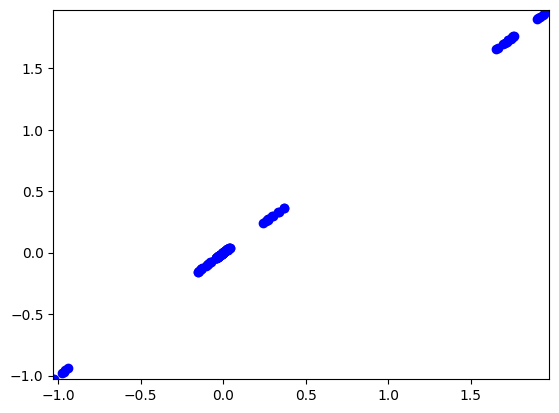

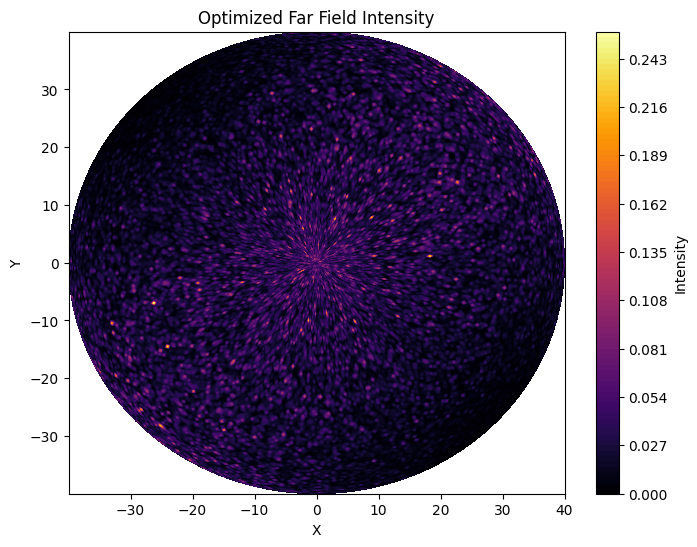

In [10]:
# Create an animation to show the movement of the dipoles over iterations
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
scat = ax.scatter([], [], c='blue')

def update(frame):
    current_positions = position_history[frame].reshape(-1, 3)
    scat.set_offsets(current_positions[:, :2])
    return scat,

ax.set_xlim(xmin = np.min(positions), xmax = np.max(positions))
ax.set_ylim(ymin = np.min(positions), ymax = np.max(positions))
ani = FuncAnimation(fig, update, frames=range(num_iterations + 1))

# Save the animation
ani.save('dipole_animation_2.mp4')

# Plot the final far field distribution
simulated_far_field = calculate_far_field(positions, wavelength, gain=1)
plt.figure(figsize=(8, 6))
plt.contourf(sim.x, sim.y, simulated_far_field, 100, cmap='inferno')
plt.colorbar(label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Optimized Far Field Intensity')
plt.show()



In [ ]:
dp.plotfarfield_2D(simulated_far_field, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="new_farfield.png")

<video src="dipole_animation.mp4" controls>

<video src="dipole_animation_1.mp4" controls>

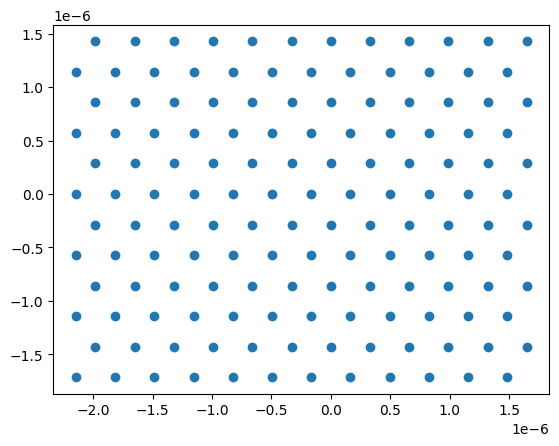

In [51]:
plt.scatter(position_history[-1].reshape(-1,3)[:, 0], position_history[-1].reshape(-1,3)[:, 1])

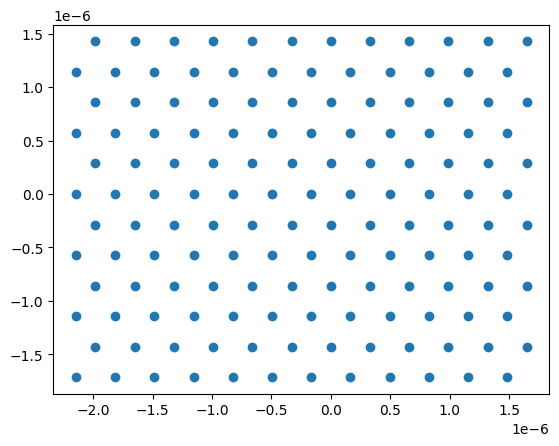

In [52]:
position_history[0].reshape(-1,3)
plt.scatter(position_history[0].reshape(-1,3)[:, 0], position_history[0].reshape(-1,3)[:, 1])

In [ ]:
# Parameters for the Gaussian beam
I0 = 2.10
theta_lim = np.pi/2
theta_res = 100
phi_res = int(2*np.pi * theta_res / theta_lim)
theta = np.linspace(0, theta_lim, theta_res)
phi = np.linspace(0, 2 * np.pi, phi_res)
Theta, Phi = np.meshgrid(theta, phi)
target_far_field = gaussian_beam(Theta, Phi, I0)

# Initialize the DipoleSimulation and load the nearfield
sim = dp.DipoleSimulation(background_index=1.4)
nearfield_default = dp.load_nearfield('matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
sim.add_nearfield(nearfield_default, "control_nearfield")
wavelength = .673e-6

# Hexagonal Grid Structure
n_rows = 20
n_cols = 20

errors = []
far_fields = []
positions = []
spacings = []
for i in np.linspace(0.1,0.99,500, endpoint = True):
    #determine the lattice constant
    spacing = i*10**-6
    align = np.array([1 * spacing / 2, 0, 0])
    spacings.append(spacing)
    
    #create the scattering grid
    scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)
    sim.scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]
    far_field = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
    far_fields.append(far_field)
    positions.append(scattering_centers)
    
    #calculate error
    errors.append(np.sum((far_field - target_far_field)**2))
    

plt.plot(np.arange(len(errors)), errors)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Analytic Far Field vs Target Distribution')
plt.show()

In [ ]:
plt.plot(spacings, errors)
plt.xlabel('Distance between Dipoles')
plt.ylabel('Error Total')
plt.title(f'Spacing that best minimizes error: {spacings[errors.index(np.min(errors))]}')
plt.show()

In [ ]:
optimal_far_field = far_fields[errors.index(np.min(errors))]
dp.plotfarfield_2D(optimal_far_field, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="spacing_optimization.png")

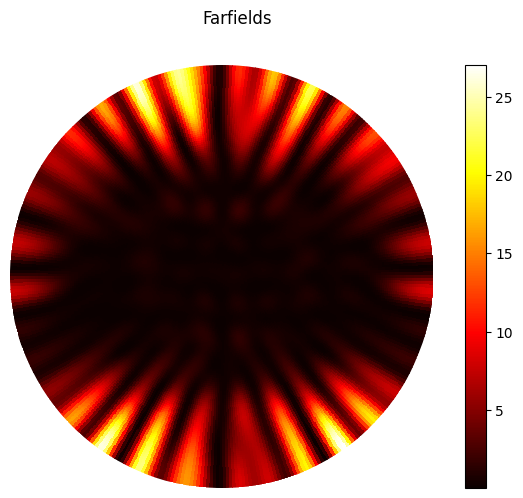

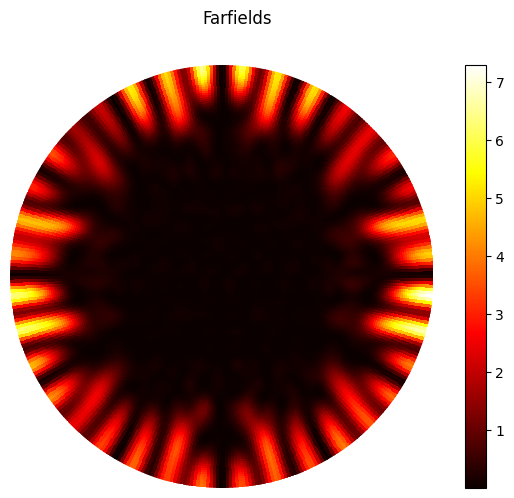

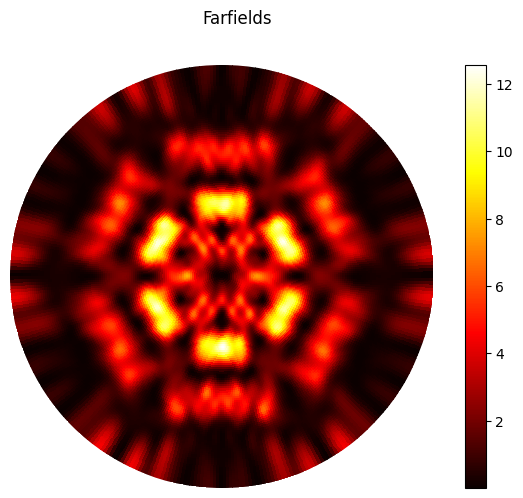

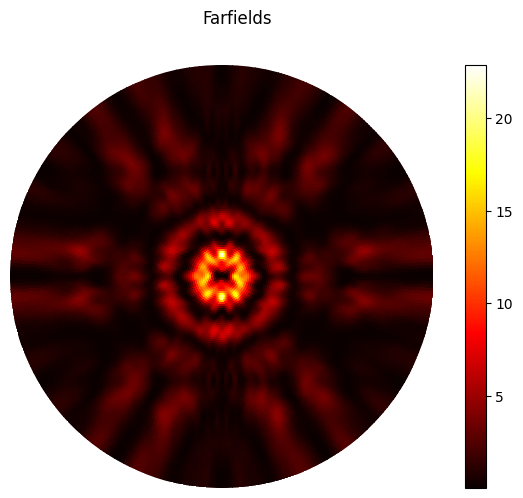

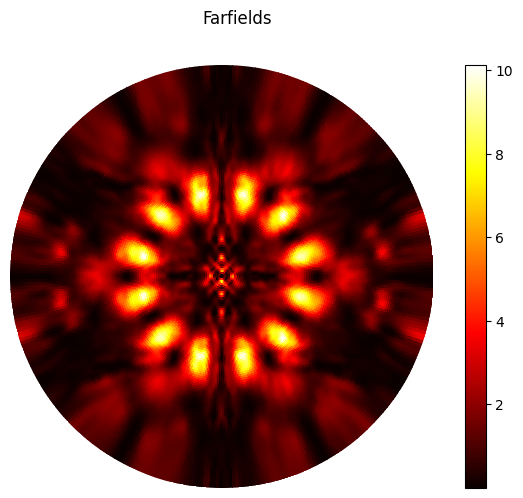

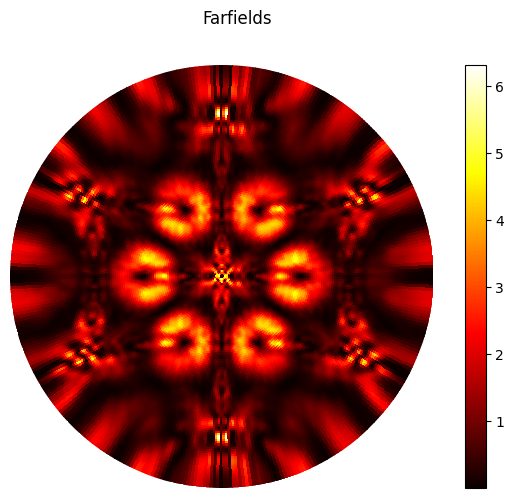

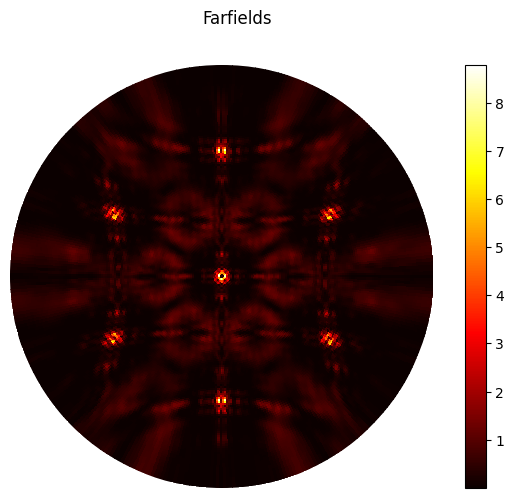

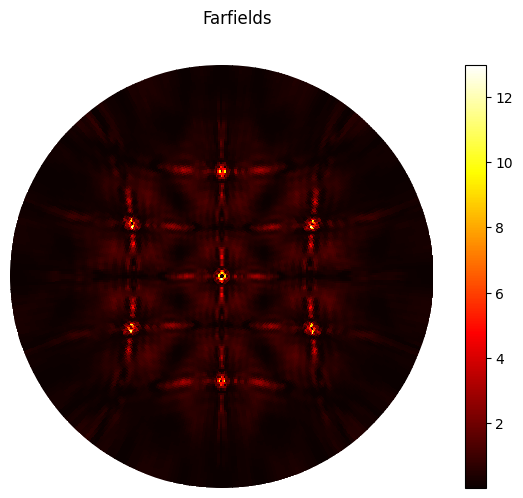

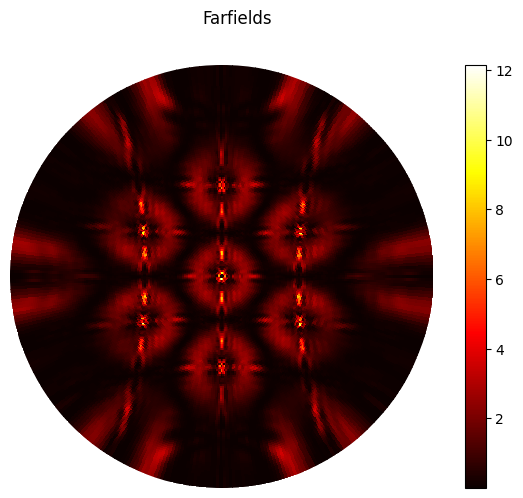

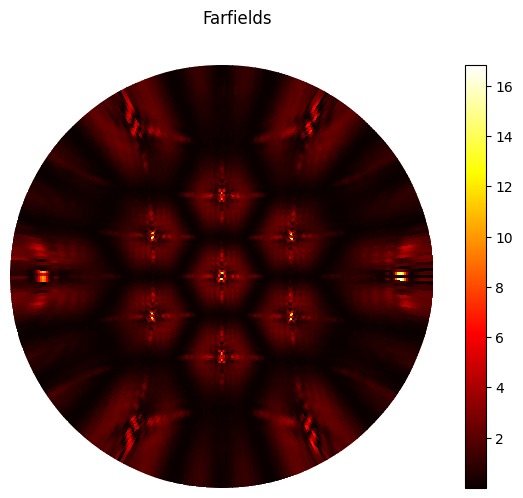

In [85]:
for i in far_fields:
    dp.plotfarfield_2D(i, theta=sim.theta, phi=sim.phi, ring30=False, ring70=False, save_file="test_image.png")